In [1]:
import pandas
import psycopg2
import sklearn.feature_extraction
import nltk
import sqlalchemy
import getpass
import scipy.stats
import math
import collections

In [ ]:
def everygram_generator(sequence, min_tokens=1, max_tokens=None):
    sequence = list(sequence)
    sequence_length = len(sequence)
    if max_tokens is None:
        max_tokens = len(sequence)
    for i in range(len(sequence)):
        for j in range(min_tokens, max_tokens+1):
            

In [2]:
username = input("Username: ")

Username: postgres


In [3]:
database_host = input("Database host: ")

Database host: thousand-language.cxuwfksdstns.ap-southeast-2.rds.amazonaws.com


In [4]:
database_name = input("Database name:")

Database name:thousand_language


In [5]:
password = getpass.getpass()

········


In [6]:
engine = sqlalchemy.create_engine(f"postgresql+psycopg2://{username}:{password}@{database_host}:5432/{database_name}")

In [7]:
bible_versions = pandas.read_sql("select * from bible_versions where version_name = 'world english bible'",
                                engine)
bible_versions

,version_id,language,grouping_code,short_code,version_name
0,59,eng,206,web,world english bible


In [8]:
world_english_version = bible_versions.iloc[0].version_id
world_english_version

59

In [9]:
singplur = pandas.read_sql(
    """select * from lemmas_with_repeated_singular_and_plural join common_nouns using (lemma, gender, noun_case)
     where noun_case in ('nominative', 'accusative')
    """, engine)
singplur['book'] = singplur.wordref.str.split('.').map(lambda x: x[1])
singplur['chapter'] = singplur.wordref.str.split('.').map(lambda x: int(x[2]))
singplur['verse'] = singplur.wordref.str.split('.').map(lambda x: int(x[3]))
singplur

,lemma,gender,noun_case,wordref,noun_number,book,chapter,verse
0,ῥάπισμα,neuter,accusative,NA28.John.18.22.w10,singular,John,18,22
1,ῥάπισμα,neuter,accusative,NA28.John.19.3.w15,plural,John,19,3
2,αἰών,masculine,accusative,NA28.Matt.21.19.w30,singular,Matt,21,19
3,αἰών,masculine,accusative,NA28.Mark.3.29.w15,singular,Mark,3,29
4,αἰών,masculine,accusative,NA28.Mark.11.14.w8,singular,Mark,11,14
...,...,...,...,...,...,...,...,...
3523,ψυχή,feminine,accusative,NA28.John.12.25.w4,singular,John,12,25
3524,ψυχή,feminine,accusative,NA28.John.12.25.w12,singular,John,12,25
3525,ψυχή,feminine,accusative,NA28.John.13.37.w14,singular,John,13,37
3526,ψυχή,feminine,accusative,NA28.John.13.38.w4,singular,John,13,38


In [10]:
world_english_bible_verses = pandas.read_sql(
    f"""select * from verses where version_id = {world_english_version}""", engine)
world_english_bible_verses

,verse_version_id,version_id,book,chapter,verse,passage
0,168113,59,Matt,3,8,Therefore produce fruit worthy of repentance!
1,166089,59,Matt,5,2,"He opened his mouth and taught them, saying,"
2,166915,59,Luke,21,33,"Heaven and earth will pass away, but my words ..."
3,166916,59,Mark,14,52,"but he left the linen cloth, and fled from the..."
4,167145,59,John,4,8,For his disciples had gone away into the city ...
...,...,...,...,...,...,...
2857,168854,59,John,7,8,You go up to the feast. I am not yet going up ...
2858,168855,59,Luke,12,5,But I will warn you whom you should fear. Fear...
2859,168856,59,Mark,3,31,"His mother and his brothers came, and standing..."
2860,168857,59,John,19,8,"When therefore Pilate heard this saying, he wa..."


In [11]:
reverse_records = []
total_verses_in_translation = 0
for (b,c,v,p) in zip(world_english_bible_verses.book, world_english_bible_verses.chapter, world_english_bible_verses.verse,
       world_english_bible_verses.passage):
    total_verses_in_translation += 1
    words = nltk.word_tokenize(p)
    # I should also create ngrams and put them here somewhere as well
    for w in words:
        reverse_records.append({'word': w, 'book': b, 'chapter': c, 'verse': v})
reverse_records_df = pandas.DataFrame.from_records(reverse_records).drop_duplicates()
reverse_records_df.sample(10)

,word,book,chapter,verse
18884,speaks,Matt,10,20
32188,saw,Matt,8,18
66962,him,John,1,37
48009,wife,Luke,18,29
64874,to,Luke,9,2
31932,.,Mark,5,38
48192,walk,Luke,20,46
15923,Magdala,Matt,15,39
59337,kingdom,Matt,12,26
7105,lifting,John,6,5


In [12]:
word_counts = reverse_records_df.word.value_counts().to_dict()

In [13]:
df = singplur.merge(world_english_bible_verses,
              left_on=['book', 'chapter', 'verse'],
              right_on=['book', 'chapter', 'verse']).drop('wordref', axis=1).drop_duplicates().set_index(
    ['lemma', 'gender', 'noun_case', 'noun_number']
).sort_index()
df

book  chapter  verse  \
lemma gender    noun_case  noun_number                         
αἰών  masculine accusative plural       Luke        1     33   
                           singular     Matt       21     19   
                           singular     Mark        3     29   
                           singular     Mark       11     14   
                           singular     Luke        1     55   
...                                      ...      ...    ...   
ῥῆμα  neuter    nominative plural       John       15      7   
                           singular     Matt       18     16   
                           singular     Luke        1     37   
                           singular     Luke        3      2   
                           singular     Luke       18     34   

                                        verse_version_id  version_id  \
lemma gender    noun_case  noun_number                                 
αἰών  masculine accusative plural                 167489          59   
                           singular               168446          59   
                           singular               166517          59   
                           singular               167809          59   
                           singular               168608          59   
...                                                  ...         ...   
ῥῆμα  neuter    nominative plural                 167688          59   
                           singular               166188          59   
                           singular               166578          59   
                           singular               166587          59   
                           singular               166299          59   

                                                                                  passage  
lemma gender    noun_case  noun_number                                                     
αἰών  masculine accusative plural       and he will reign over the house of Jacob fore...  
                           singular     Seeing a fig tree by the road, he came to it, ...  
                           singular     but whoever may blaspheme against the Holy Spi...  
                           singular     Jesus told it, “May no one ever eat fruit from...  
                           singular     As he spoke to our fathers, to Abraham and his...  
...                                                                                   ...  
ῥῆμα  neuter    nominative plural       If you remain in me, and my words remain in yo...  
                           singular     But if he doesn’t listen, take one or two more...  
                           singular             For nothing spoken by God is impossible.”  
                           singular     in the high priesthood of Annas and Caiaphas, ...  
                           singular     They understood none of these things. This say...  

[3361 rows x 6 columns]

In [14]:
%%time
translation_records = []
for row in df.index.unique():
    temp_df = df.loc[row]
    ngram_appearances_in_verses = collections.defaultdict(int)
    total_verses = 0
    for passage in temp_df.passage:
        total_verses += 1
        words = nltk.word_tokenize(passage)
        # Here I should make ngrams
        # I should also have a variant where I look at glyph-level n-grams
        for word in set(words):
            ngram_appearances_in_verses[word] += 1
    for word in ngram_appearances_in_verses:
        appearances_anywhere = reverse_records_df[reverse_records_df.word == word]
        probability_of_seeing_this_word = appearances_anywhere.shape[0] / total_verses_in_translation
        count_we_saw = ngram_appearances_in_verses[word]
        number_of_places_it_might_have_been = total_verses
        probability = scipy.stats.binom_test(count_we_saw,
                                            number_of_places_it_might_have_been,
                                            probability_of_seeing_this_word,
                                            alternative='greater')
        translation_records.append({
            'lemma': row[0],
            'gender': row[1],
            'noun_case': row[2],
            'noun_number': row[3],
            'translation': word,
            'binomial_test_p_score': probability,
            'neg_log_binomial_test_p_score': - math.log(probability),
            'appearances': appearances_anywhere.shape[0],
            'total_verses_in_translation': total_verses_in_translation,
            'probability_of_seeing_this_word': probability_of_seeing_this_word,
            'count_we_saw': count_we_saw,
            'number_of_places_we_saw_the_lemma': total_verses
        })
translation_df = pandas.DataFrame.from_records(translation_records)
translation_df.sample(10)

CPU times: user 1min 59s, sys: 240 ms, total: 1min 59s
Wall time: 1min 59s


,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma
23903,ψυχή,feminine,accusative,singular,not,0.314864,1.155614,235,2862,0.082110,3,24
14658,πατήρ,masculine,nominative,plural,men,0.204444,1.587463,92,2862,0.032145,1,7
16464,ποιμήν,masculine,nominative,singular,separates,0.002095,6.168390,1,2862,0.000349,1,6
33513,ὄνομα,neuter,nominative,singular,pray,0.006936,4.971034,20,2862,0.006988,2,18
13941,παραβολή,feminine,accusative,singular,this,0.000083,9.392345,275,2862,0.096087,10,26
2146,γυνή,feminine,accusative,singular,brought,0.378392,0.971824,45,2862,0.015723,1,30
6513,καιρός,masculine,nominative,singular,go,0.223320,1.499148,89,2862,0.031097,1,8
21872,υἱός,masculine,nominative,singular,Spirit,0.270343,1.308063,41,2862,0.014326,3,126
19723,σῶμα,neuter,nominative,singular,!,0.603500,0.505009,183,2862,0.063941,1,14
10514,μήτηρ,feminine,accusative,singular,for,0.256095,1.362207,471,2862,0.164570,5,21


In [15]:
best_translations = translation_df.groupby(['lemma', 'gender', 'noun_case', 'noun_number']
                                          ).binomial_test_p_score.idxmin().reset_index()
best_translations.rename(columns={'binomial_test_p_score': 'best_p_score_index'}, inplace=True)
noun_vocab = best_translations[['best_p_score_index']].merge(translation_df,
                        left_on=['best_p_score_index'],
                        right_index=True
                       )
noun_vocab

,best_p_score_index,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma
0,13,αἰών,masculine,accusative,plural,reign,6.988120e-04,7.266129,2,2862,0.000699,1,1
1,29,αἰών,masculine,accusative,singular,forever,1.914199e-14,31.586892,9,2862,0.003145,7,15
2,196,βαλλάντιον,neuter,accusative,plural,destroys,3.494060e-04,7.959276,1,2862,0.000349,1,1
3,233,βαλλάντιον,neuter,accusative,singular,purse,1.098761e-06,13.721327,3,2862,0.001048,2,2
4,270,βασιλεία,feminine,accusative,plural,kingdoms,4.883382e-07,14.532258,2,2862,0.000699,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,35133,ὥρα,feminine,nominative,singular,hour,2.621945e-25,56.600711,53,2862,0.018519,18,27
375,35384,ῥῆμα,neuter,accusative,plural,words,3.267178e-10,21.841924,31,2862,0.010832,6,10
376,35586,ῥῆμα,neuter,accusative,singular,understand,3.210422e-05,10.346523,21,2862,0.007338,3,9
377,35664,ῥῆμα,neuter,nominative,plural,words,1.250239e-05,11.289590,31,2862,0.010832,3,5


In [16]:
confidences = []
for row_idx in noun_vocab.index:
    lemma = noun_vocab.loc[row_idx].lemma
    gender = noun_vocab.loc[row_idx].gender
    noun_case = noun_vocab.loc[row_idx].noun_case
    noun_number = noun_vocab.loc[row_idx].noun_number
    translation = noun_vocab.loc[row_idx].translation
    neg_log_binomial_test_p_score  = noun_vocab.loc[row_idx].neg_log_binomial_test_p_score
    alternatives = translation_df[
            (translation_df.lemma == lemma) & 
            (translation_df.gender == gender) & 
            (translation_df.noun_case == noun_case) & 
            (translation_df.noun_number == noun_number) & 
            (translation_df.translation != translation)
    ]
    next_best = alternatives.neg_log_binomial_test_p_score.max()
    #print(lemma, gender, noun_case, noun_number, neg_log_binomial_test_p_score, next_best)
    confidences.append(neg_log_binomial_test_p_score / next_best)
noun_vocab['confidence'] = confidences
noun_vocab.sort_values('confidence')

,best_p_score_index,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma,confidence
378,35690,ῥῆμα,neuter,nominative,singular,established,1.396892e-03,6.573506,1,2862,0.000349,1,4,1.000000
248,22450,φραγμός,masculine,accusative,plural,hedges,3.494060e-04,7.959276,1,2862,0.000349,1,1,1.000000
315,29295,ἄρχων,masculine,accusative,singular,magistrate,3.494060e-04,7.959276,1,2862,0.000349,1,1,1.000000
206,18531,σεισμός,masculine,nominative,plural,famines,1.151741e-09,20.581991,3,2862,0.001048,3,3,1.000000
304,27480,ἄνεμος,masculine,nominative,plural,blew,1.464332e-06,13.434111,2,2862,0.000699,2,3,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,11584,μαθητής,masculine,nominative,singular,disciple,3.026435e-34,77.180508,23,2862,0.008036,16,16,7.422864
243,20889,τόπος,masculine,accusative,singular,place,2.376947e-45,102.750512,55,2862,0.019217,26,26,7.858065
71,5598,θεός,masculine,nominative,singular,God,3.140511e-45,102.471944,239,2862,0.083508,44,46,8.868653
133,11067,μαθητής,masculine,nominative,plural,disciples,7.978174e-122,278.838672,181,2862,0.063242,101,101,9.115994


In [17]:
output = noun_vocab.sort_values('confidence')
output['is_correct'] = ''
output.to_csv('/tmp/vocab-with-confidence.csv')

In [18]:
multi_number_nouns = noun_vocab.groupby(['lemma', 'gender', 'noun_case']).noun_number.nunique()
multi_number_nouns = multi_number_nouns[multi_number_nouns > 1]

In [19]:
word_number_pairs = []
for (lemma, gender, noun_case) in multi_number_nouns.index:
    singular = noun_vocab[(noun_vocab.lemma == lemma) &
                              (noun_vocab.gender == gender) &
                              (noun_vocab.noun_case == noun_case) &
                              (noun_vocab.noun_number == 'singular')
                             ].translation.iloc[0]
    plural = noun_vocab[(noun_vocab.lemma == lemma) &
                              (noun_vocab.gender == gender) &
                              (noun_vocab.noun_case == noun_case) &
                              (noun_vocab.noun_number == 'plural')
                             ].translation.iloc[0]
    word_number_pairs.append({'lemma': lemma, 'noun_case': noun_case, 'gender': gender,
                              'singular': singular, 'plural': plural})
word_number_pairs = pandas.DataFrame.from_records(word_number_pairs)
word_number_pairs.to_csv('/tmp/word-pairs.csv', index=False)
word_number_pairs

,lemma,noun_case,gender,singular,plural
0,αἰών,accusative,masculine,forever,reign
1,βαλλάντιον,accusative,neuter,purse,destroys
2,βασιλεία,accusative,feminine,Kingdom,kingdoms
3,βασιλεύς,accusative,masculine,king,governors
4,βιβλίον,accusative,neuter,divorce,books
...,...,...,...,...,...
172,ὅρκος,accusative,masculine,swore,oaths
173,ὕδωρ,accusative,neuter,water,waters
174,ὥρα,nominative,feminine,hour,hours
175,ῥῆμα,accusative,neuter,understand,words


In [20]:
translation_df[translation_df.lemma == 'γεωργός'].sort_values('binomial_test_p_score').head(20)

,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma
1379,γεωργός,masculine,nominative,plural,farmers,1.295860e-12,27.371847,12,2862,0.004193,5,5
1403,γεωργός,masculine,nominative,plural,heir,1.149931e-08,18.280979,3,2862,0.001048,3,5
1404,γεωργός,masculine,nominative,plural,inheritance,2.724333e-08,17.418457,4,2862,0.001398,3,5
1399,γεωργός,masculine,nominative,plural,Come,2.896791e-06,12.751907,19,2862,0.006639,3,5
1392,γεωργός,masculine,nominative,plural,kill,3.376895e-06,12.598554,20,2862,0.006988,3,5
1407,γεωργός,masculine,nominative,plural,ours,4.876561e-06,12.231070,2,2862,0.000699,2,5
1396,γεωργός,masculine,nominative,plural,themselves,1.133708e-05,11.387432,30,2862,0.010482,3,5
1394,γεωργός,masculine,nominative,plural,let,4.052611e-05,10.113564,46,2862,0.016073,3,5
1386,γεωργός,masculine,nominative,plural,This,9.375435e-05,9.274833,61,2862,0.021314,3,5
1389,γεωργός,masculine,nominative,plural,among,1.184344e-04,9.041152,66,2862,0.023061,3,5


In [21]:
translation_df[(translation_df.lemma == 'διάκονος')
               & 
              (translation_df.noun_number == 'plural')].sort_values('binomial_test_p_score').head(20)

,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma
3792,διάκονος,masculine,nominative,plural,drawn,0.000349,7.959276,1,2862,0.000349,1,1
3783,διάκονος,masculine,nominative,plural,tasted,0.000699,7.266129,2,2862,0.000699,1,1
3771,διάκονος,masculine,nominative,plural,bridegroom,0.003494,5.656691,10,2862,0.003494,1,1
3798,διάκονος,masculine,nominative,plural,ruler,0.003843,5.561381,11,2862,0.003843,1,1
3782,διάκονος,masculine,nominative,plural,wine,0.005241,5.251226,15,2862,0.005241,1,1
3789,διάκονος,masculine,nominative,plural,become,0.006639,5.014837,19,2862,0.006639,1,1
3774,διάκονος,masculine,nominative,plural,),0.007338,4.914754,21,2862,0.007338,1,1
3797,διάκονος,masculine,nominative,plural,(,0.007687,4.868234,22,2862,0.007687,1,1
3785,διάκονος,masculine,nominative,plural,knew,0.008036,4.823782,23,2862,0.008036,1,1
3795,διάκονος,masculine,nominative,plural,feast,0.010482,4.558079,30,2862,0.010482,1,1


<AxesSubplot:ylabel='Frequency'>

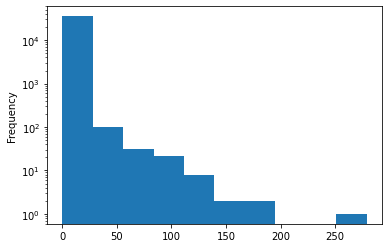

In [22]:
translation_df.neg_log_binomial_test_p_score.plot.hist(logy=True)

In [23]:
singplur[singplur.lemma == 'ἀρχιερεύς']

,lemma,gender,noun_case,wordref,noun_number,book,chapter,verse
2693,ἀρχιερεύς,masculine,accusative,NA28.Matt.2.4.w5,plural,Matt,2,4
2694,ἀρχιερεύς,masculine,accusative,NA28.Matt.26.14.w12,plural,Matt,26,14
2695,ἀρχιερεύς,masculine,accusative,NA28.Matt.26.57.w10,singular,Matt,26,57
2696,ἀρχιερεύς,masculine,accusative,NA28.Mark.14.10.w11,plural,Mark,14,10
2697,ἀρχιερεύς,masculine,accusative,NA28.Mark.14.53.w7,singular,Mark,14,53
2698,ἀρχιερεύς,masculine,accusative,NA28.Luke.22.52.w9,plural,Luke,22,52
2699,ἀρχιερεύς,masculine,accusative,NA28.Luke.23.4.w7,plural,Luke,23,4
2700,ἀρχιερεύς,masculine,accusative,NA28.Luke.23.13.w5,plural,Luke,23,13
2701,ἀρχιερεύς,masculine,accusative,NA28.John.7.45.w7,plural,John,7,45
2702,ἀρχιερεύς,masculine,accusative,NA28.John.18.24.w10,singular,John,18,24


In [24]:
vwc = pandas.read_csv('vocab-with-confidence.csv')
vwc

,Unnamed: 0,best_p_score_index,lemma,gender,noun_case,noun_number,translation,binomial_test_p_score,neg_log_binomial_test_p_score,appearances,total_verses_in_translation,probability_of_seeing_this_word,count_we_saw,number_of_places_we_saw_the_lemma,confidence,is_correct
0,140,14125,ῥῆμα,neuter,nominative,singular,established,1.396892e-03,6.573506,1,2862,0.000349,1,4,1.000000,n
1,53,4593,μέριμνα,feminine,nominative,singular,deceitfulness,6.988120e-04,7.266129,2,2862,0.000699,1,1,1.000000,n
2,48,4399,λύκος,masculine,nominative,singular,scatters,3.494060e-04,7.959276,1,2862,0.000349,1,1,1.000000,n
3,42,4006,λιμός,feminine,nominative,plural,famines,1.098761e-06,13.721327,3,2862,0.001048,2,2,1.000000,y
4,74,6917,ποταμός,masculine,nominative,plural,blew,1.464332e-06,13.434111,2,2862,0.000699,2,3,1.000000,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,65,5853,πατήρ,masculine,nominative,singular,Father,3.802153e-75,171.358314,149,2862,0.052061,71,87,7.154656,y
137,96,9435,ἀδελφός,masculine,nominative,singular,brother,8.364577e-39,87.676813,44,2862,0.015374,21,21,7.244986,y
138,55,5116,μαθητής,masculine,nominative,singular,disciple,3.026435e-34,77.180508,23,2862,0.008036,16,16,7.422864,y
139,22,2189,θεός,masculine,nominative,singular,God,3.140511e-45,102.471944,239,2862,0.083508,44,46,8.868653,y
